C:\Users\haochen shi\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Epoch 1/100
42/42 [==============================] - 5s 11ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 9.8180e-04 - val_loss: 0.0011
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 9.5685e-04 - val_loss: 0.0010
Epoch 8/100
42/42 [==============================] - 0s 4ms/step - loss: 9.5424e-04 - val_loss: 0.0010
Epoch 9/100
42/42 [==============================] - 0s 4ms/step - loss: 9.5999e-04 - val_loss: 9.9266e-04
Epoch 10/100
42/42 [==============================] - 0s 4ms/step - loss: 9.4476e-04 - v

42/42 [==============================] - 0s 4ms/step - loss: 6.9539e-04 - val_loss: 9.5729e-04
Epoch 79/100
42/42 [==============================] - 0s 4ms/step - loss: 6.5929e-04 - val_loss: 9.9722e-04
Epoch 80/100
42/42 [==============================] - 0s 4ms/step - loss: 6.6379e-04 - val_loss: 9.8871e-04
Epoch 81/100
42/42 [==============================] - 0s 4ms/step - loss: 6.8400e-04 - val_loss: 9.4865e-04
Epoch 82/100
42/42 [==============================] - 0s 4ms/step - loss: 6.6430e-04 - val_loss: 0.0011
Epoch 83/100
42/42 [==============================] - 0s 5ms/step - loss: 6.7707e-04 - val_loss: 9.9741e-04
Epoch 84/100
42/42 [==============================] - 0s 4ms/step - loss: 6.6720e-04 - val_loss: 0.0010
Epoch 85/100
42/42 [==============================] - 0s 4ms/step - loss: 6.8786e-04 - val_loss: 0.0010
Epoch 86/100
42/42 [==============================] - 0s 4ms/step - loss: 6.4519e-04 - val_loss: 0.0010
Epoch 87/100
42/42 [==============================] - 0s 

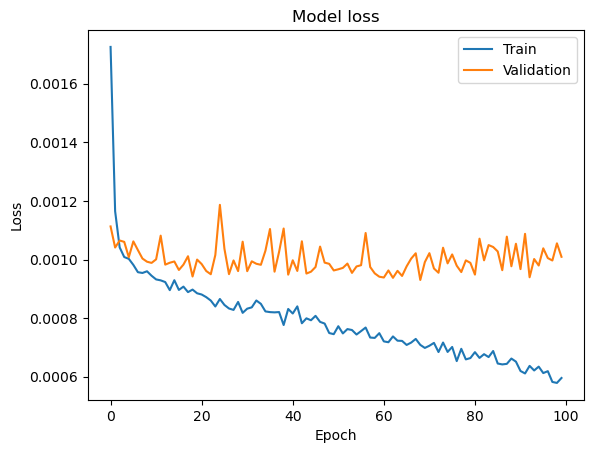

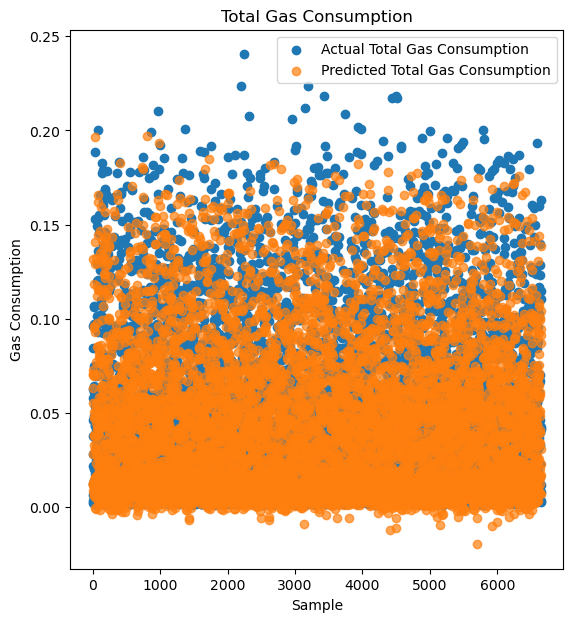

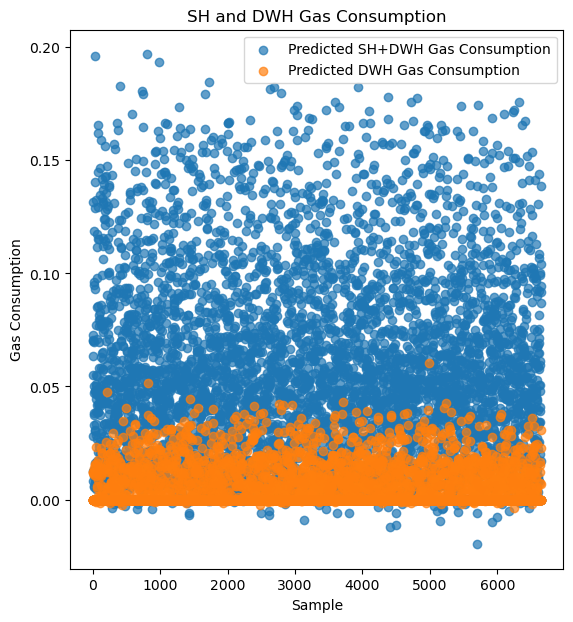

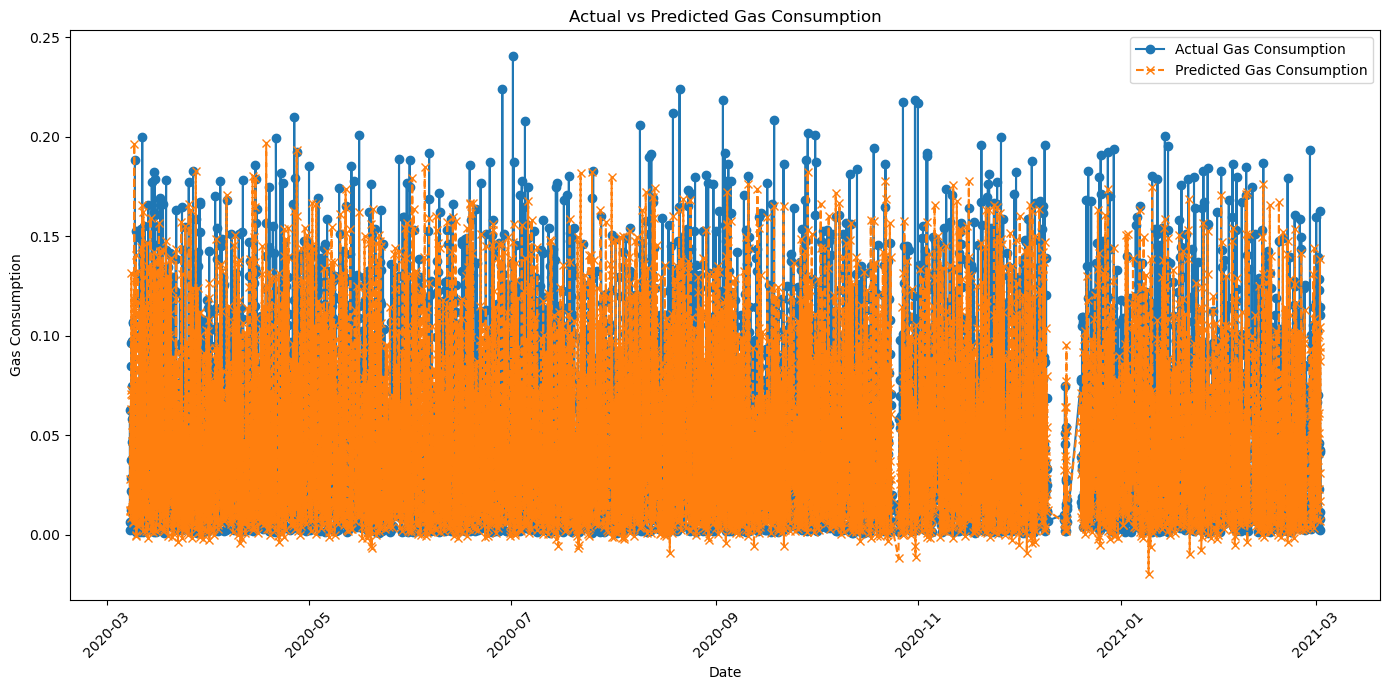

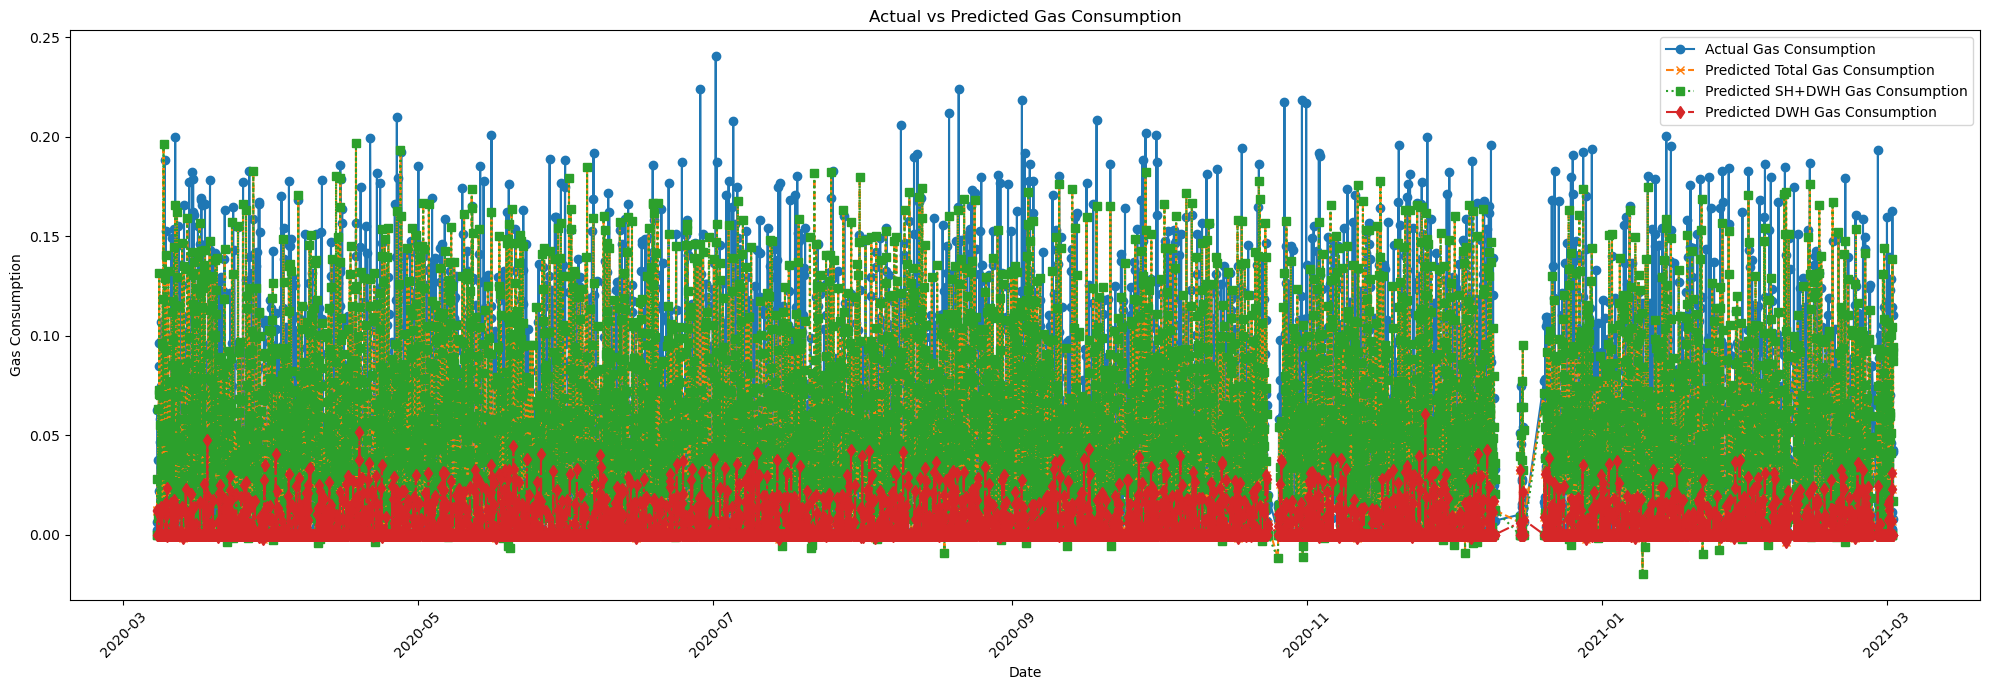

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the data
daily_stat = pd.read_csv('hourly_stat.csv').dropna()

# Ensure the date column is parsed as datetime
daily_stat['date'] = pd.to_datetime(daily_stat['date'])

# Extract features and target
features = daily_stat[['SH_temp_mean', 'SH_hum_mean', 'DWH_temp_mean', 'DWH_hum_mean', 'ext_temp_mean', 'ext_hum_mean']]
target = daily_stat['Gas_mean']

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data while keeping the date for plotting
X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(features_scaled, target, daily_stat['date'], test_size=0.8, random_state=42)

# Ensure dates are sorted
date_test = pd.Series(date_test).sort_values().reset_index(drop=True)
date_train = pd.Series(date_train).sort_values().reset_index(drop=True)


# Reshape data for RNN input (samples, time steps, features)
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build RNN model
model = Sequential()
model.add(LSTM(192, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dense(8, activation='linear'))
model.add(Dense(4, activation='linear'))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Predict gas consumption on the test set
predictions = model.predict(X_test_rnn).flatten()

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

# Assuming SH periods are marked in your dataset, create boolean masks for SH and DWH periods
external_temp_test = X_test[:, 4] * scaler.scale_[4] + scaler.mean_[4]  # Reverse normalization for external temp
sh_dwh_periods = external_temp_test < 15
dwh_periods = external_temp_test >= 15

# For simplicity, assume gas consumption for SH and DWH can be linearly decomposed
sh_dwh_contributions = predictions * sh_dwh_periods
dwh_contributions = predictions * dwh_periods

# Plot training loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Compare actual vs predicted SH and DWH gas consumption
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, label='Actual Total Gas Consumption')
plt.scatter(range(len(y_test)), predictions, label='Predicted Total Gas Consumption', alpha=0.7)
plt.title('Total Gas Consumption')
plt.xlabel('Sample')
plt.ylabel('Gas Consumption')
plt.legend()

plt.show()

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), sh_dwh_contributions, label='Predicted SH+DWH Gas Consumption', alpha=0.7)
plt.scatter(range(len(y_test)), dwh_contributions, label='Predicted DWH Gas Consumption', alpha=0.7)
plt.title('SH and DWH Gas Consumption')
plt.xlabel('Sample')
plt.ylabel('Gas Consumption')
plt.legend()

plt.show()

# Plot actual vs predicted gas consumption over time
plt.figure(figsize=(14, 7))
plt.plot(date_test, y_test, label='Actual Gas Consumption', marker='o')
plt.plot(date_test, predictions, label='Predicted Gas Consumption', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Gas Consumption')
plt.title('Actual vs Predicted Gas Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot actual vs predicted gas consumption over time with SH and DWH contributions
plt.figure(figsize=(20, 7))
plt.plot(date_test, y_test, label='Actual Gas Consumption', marker='o')
plt.plot(date_test, predictions, label='Predicted Total Gas Consumption', marker='x', linestyle='--')
plt.plot(date_test, sh_dwh_contributions, label='Predicted SH+DWH Gas Consumption', marker='s', linestyle=':')
plt.plot(date_test, dwh_contributions, label='Predicted DWH Gas Consumption', marker='d', linestyle='-.')

plt.xlabel('Date')
plt.ylabel('Gas Consumption')
plt.title('Actual vs Predicted Gas Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Epoch 1/100
167/167 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 2/100
167/167 [==============================] - 1s 4ms/step - loss: 9.6988e-04 - val_loss: 0.0011
Epoch 3/100
167/167 [==============================] - 1s 4ms/step - loss: 9.5729e-04 - val_loss: 0.0010
Epoch 4/100
167/167 [==============================] - 1s 4ms/step - loss: 9.2601e-04 - val_loss: 9.8478e-04
Epoch 5/100
167/167 [==============================] - 1s 4ms/step - loss: 9.1740e-04 - val_loss: 0.0010
Epoch 6/100
167/167 [==============================] - 1s 4ms/step - loss: 9.1437e-04 - val_loss: 9.7010e-04
Epoch 7/100
167/167 [==============================] - 1s 4ms/step - loss: 9.0993e-04 - val_loss: 9.7869e-04
Epoch 8/100
167/167 [==============================] - 1s 4ms/step - loss: 8.9759e-04 - val_loss: 9.8032e-04
Epoch 9/100
167/167 [==============================] - 1s 4ms/step - loss: 8.9276e-04 - val_loss: 0.0010
Epoch 10/100
167/167 [=====================

Epoch 76/100
167/167 [==============================] - 1s 4ms/step - loss: 6.6505e-04 - val_loss: 9.2914e-04
Epoch 77/100
167/167 [==============================] - 1s 4ms/step - loss: 6.6495e-04 - val_loss: 8.9978e-04
Epoch 78/100
167/167 [==============================] - 1s 4ms/step - loss: 6.5466e-04 - val_loss: 8.8449e-04
Epoch 79/100
167/167 [==============================] - 1s 4ms/step - loss: 6.6147e-04 - val_loss: 9.0873e-04
Epoch 80/100
167/167 [==============================] - 1s 4ms/step - loss: 6.6482e-04 - val_loss: 8.7301e-04
Epoch 81/100
167/167 [==============================] - 1s 4ms/step - loss: 6.4332e-04 - val_loss: 8.9740e-04
Epoch 82/100
167/167 [==============================] - 1s 4ms/step - loss: 6.5480e-04 - val_loss: 8.7662e-04
Epoch 83/100
167/167 [==============================] - 1s 4ms/step - loss: 6.5934e-04 - val_loss: 8.9432e-04
Epoch 84/100
167/167 [==============================] - 1s 4ms/step - loss: 6.4321e-04 - val_loss: 9.0317e-04
Epoch 85/1

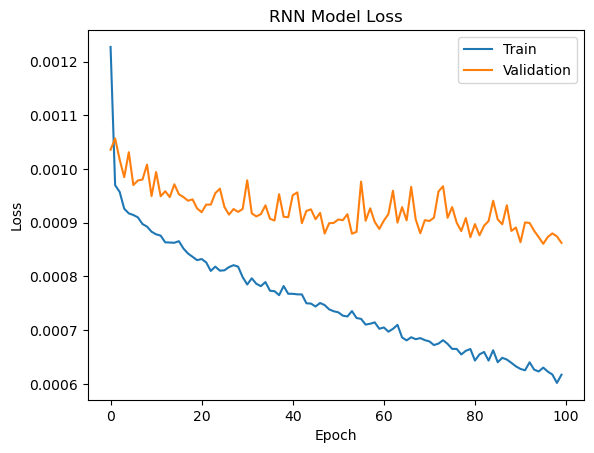

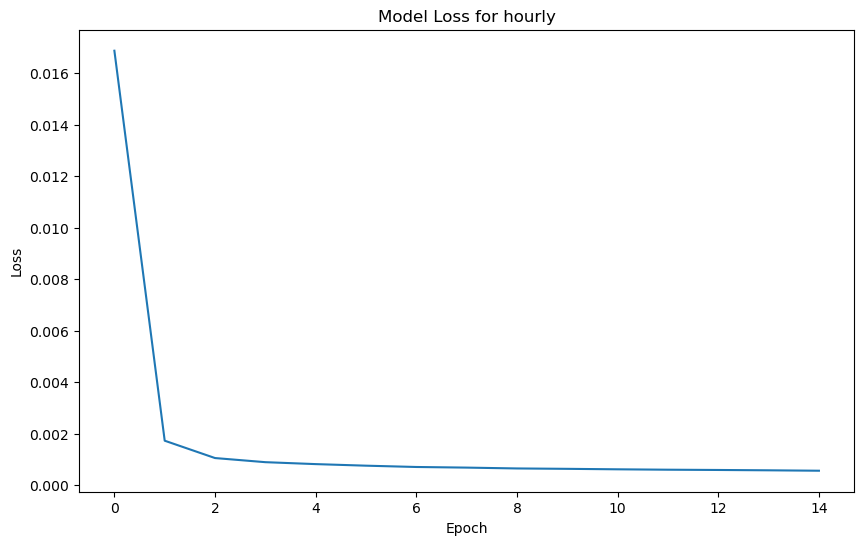

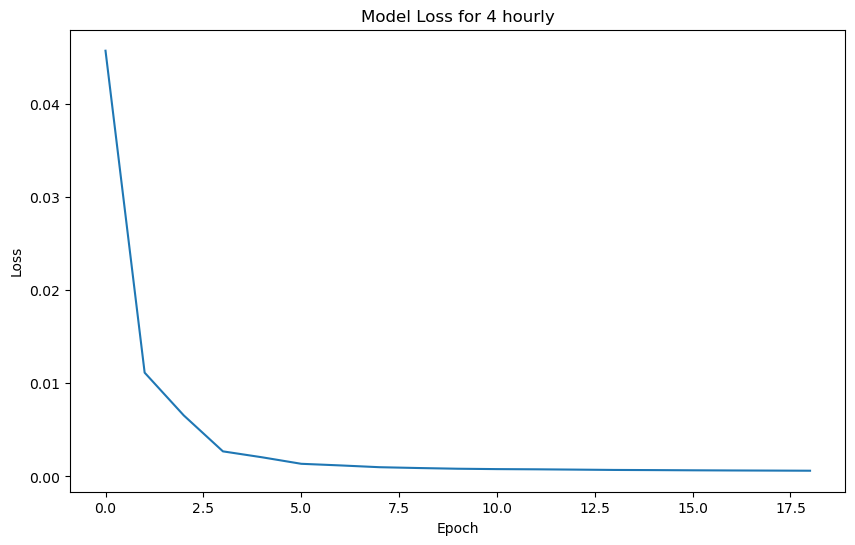

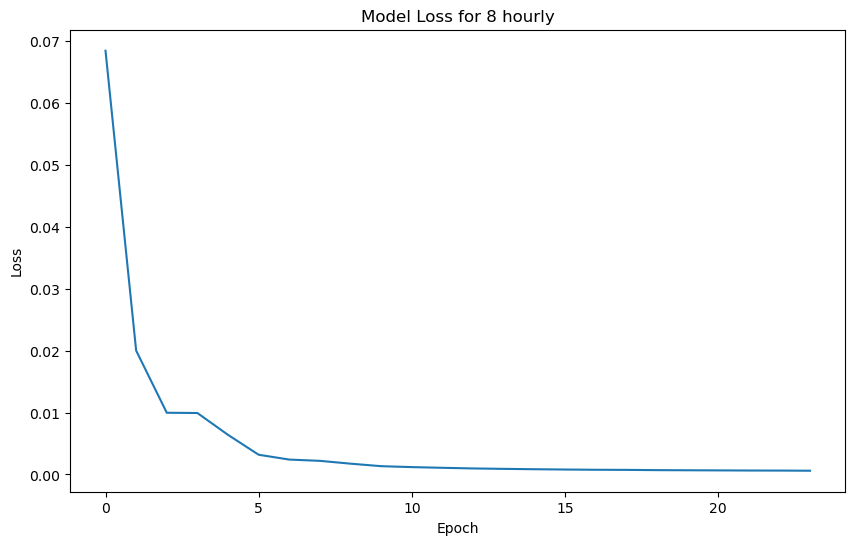

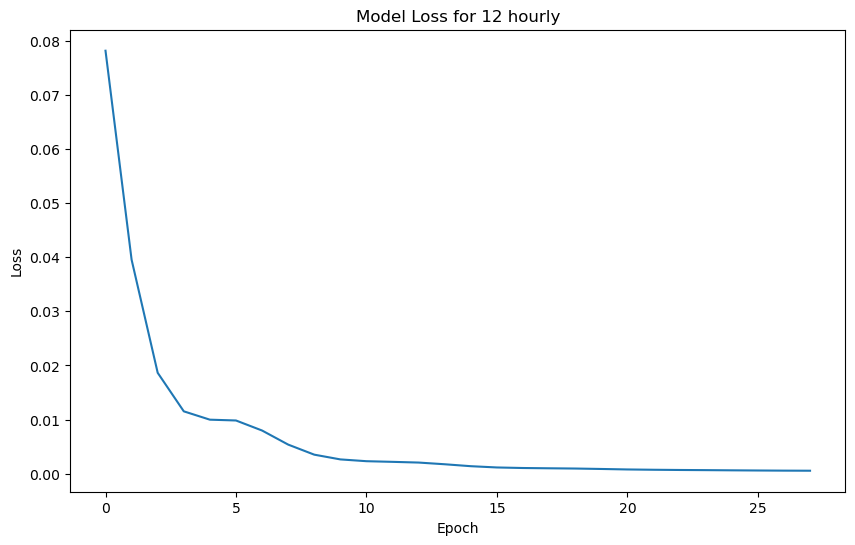

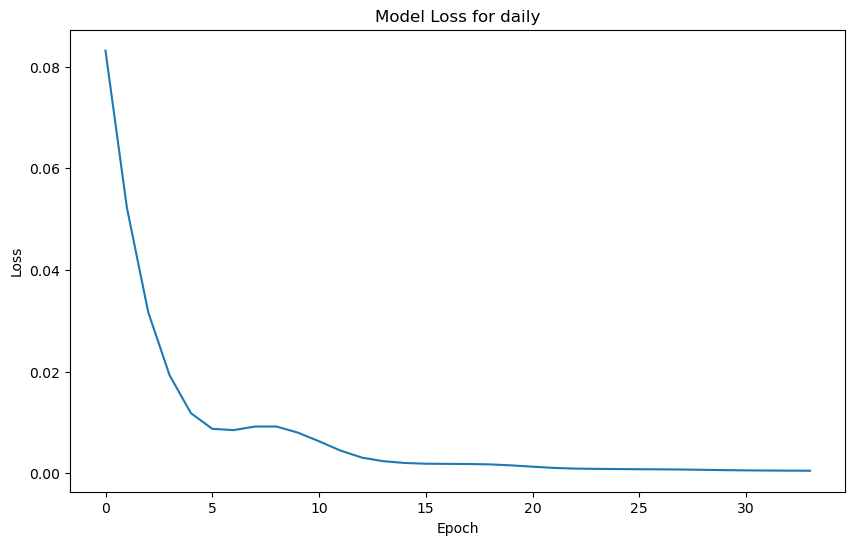

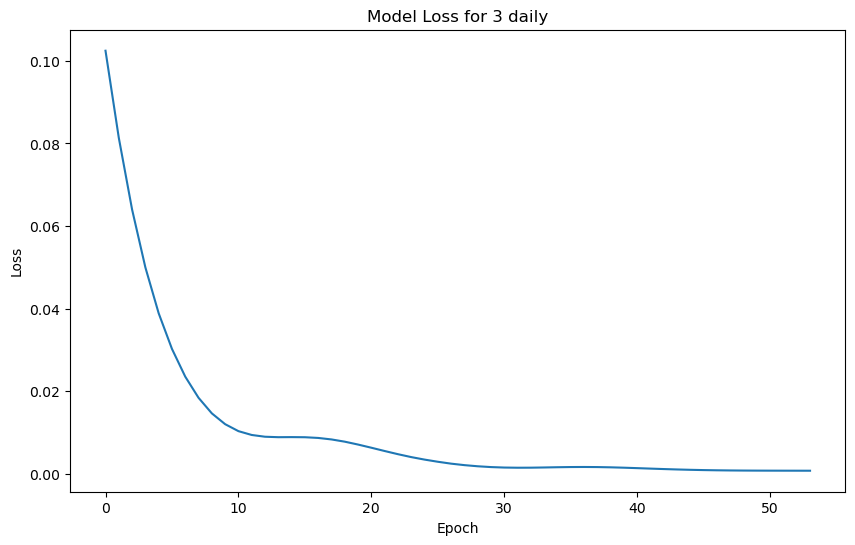

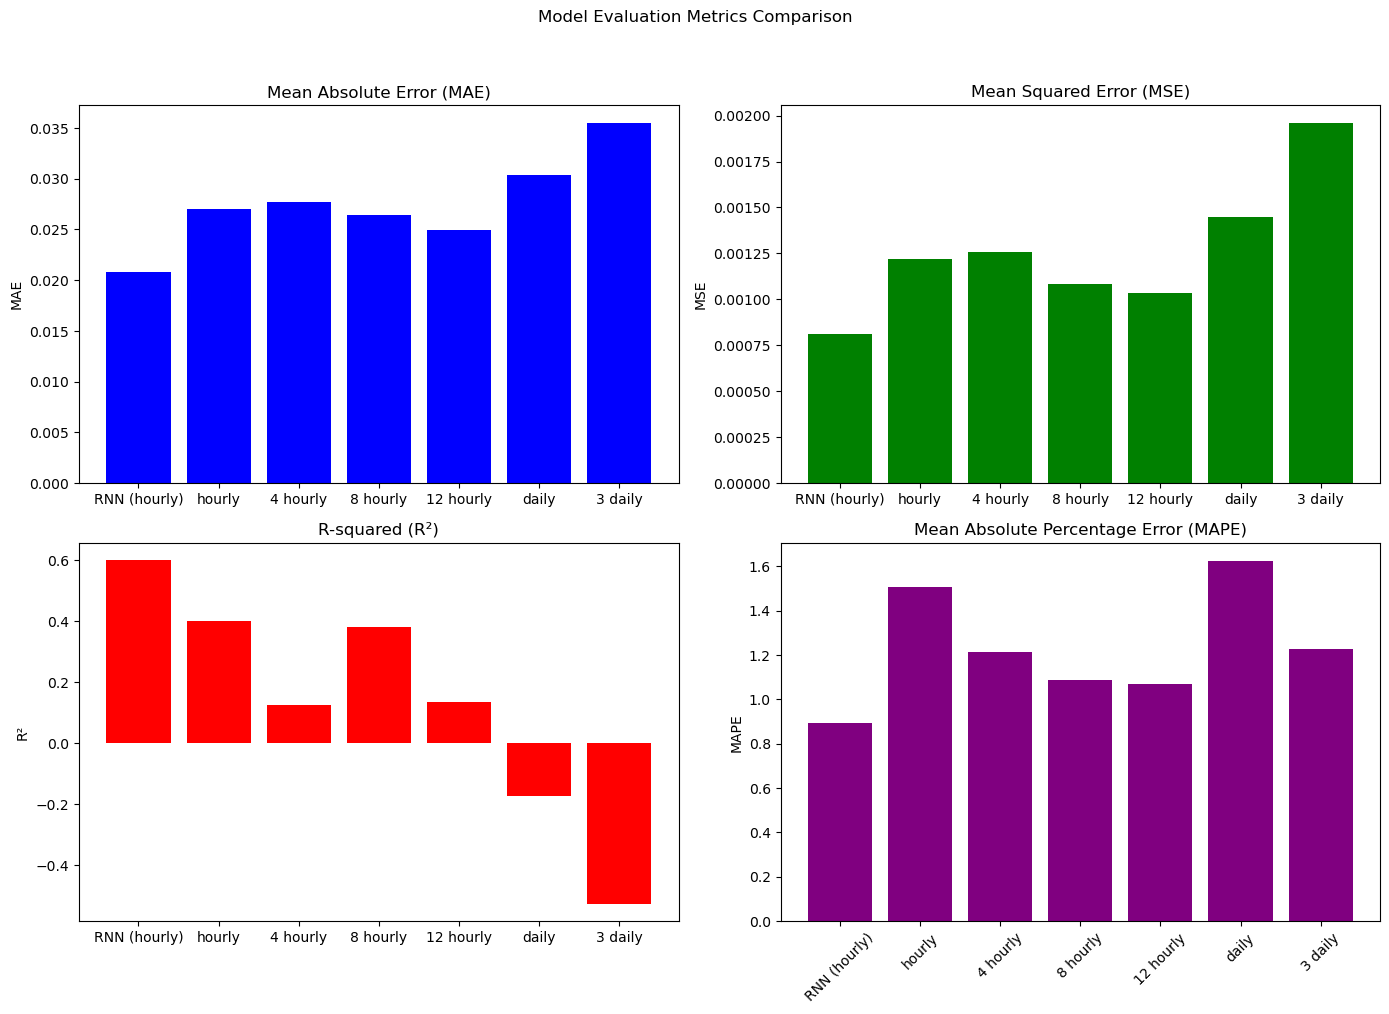

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.neural_network import MLPRegressor

# Define a function to train and evaluate a model
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    
    return model, predictions, mae, mse, r2, mape

# Function to reshape data for RNN input
def reshape_rnn_input(data):
    return data.reshape((data.shape[0], 1, data.shape[1]))

# Load and prepare data for the RNN model
daily_stat = pd.read_csv('hourly_stat.csv').dropna()
daily_stat['date'] = pd.to_datetime(daily_stat['date'])
features = daily_stat[['SH_temp_mean', 'SH_hum_mean', 'DWH_temp_mean', 'DWH_hum_mean', 'ext_temp_mean', 'ext_hum_mean']]
target = daily_stat['Gas_mean']
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(features_scaled, target, daily_stat['date'], test_size=0.2, random_state=42)
X_train_rnn = reshape_rnn_input(X_train)
X_test_rnn = reshape_rnn_input(X_test)

# Build and train the RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(192, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu', return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(32, activation='relu'))
rnn_model.add(Dense(8, activation='linear'))
rnn_model.add(Dense(4, activation='linear'))
rnn_model.add(Dense(1, activation='linear'))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
history_rnn = rnn_model.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.2)
rnn_predictions = rnn_model.predict(X_test_rnn).flatten()

# Calculate evaluation metrics for the RNN model
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_r2 = r2_score(y_test, rnn_predictions)
rnn_mape = mean_absolute_percentage_error(y_test, rnn_predictions)

# Plot training loss values for the RNN model
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Prepare datasets for different time periods for MLP models
datasets = {
    "hourly": pd.read_csv('hourly_stat.csv').dropna(),
    "4 hourly": pd.read_csv('hourly_4_stat.csv').dropna(),
    "8 hourly": pd.read_csv('hourly_8_stat.csv').dropna(),
    "12 hourly": pd.read_csv('hourly_12_stat.csv').dropna(),
    "daily": pd.read_csv('daily_stat.csv').dropna(),
    "3 daily": pd.read_csv('3_daily_stat.csv').dropna()
}

# Initialize metrics dictionary
metrics = {
    "Model": ["RNN (hourly)"],
    "MAE": [rnn_mae],
    "MSE": [rnn_mse],
    "R²": [rnn_r2],
    "MAPE": [rnn_mape]
}

# Train and evaluate MLP models for each dataset
for period, data in datasets.items():
    features = data[['SH_temp_mean', 'SH_hum_mean', 'DWH_temp_mean', 'DWH_hum_mean', 'ext_temp_mean', 'ext_hum_mean']].dropna()
    target = data['Gas_mean'].dropna()
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
    model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
    
    trained_model, predictions, mae, mse, r2, mape = train_and_evaluate_model(model, X_train, X_test, y_train, y_test)
    
    metrics["Model"].append(period)
    metrics["MAE"].append(mae)
    metrics["MSE"].append(mse)
    metrics["R²"].append(r2)
    metrics["MAPE"].append(mape)

    # Plotting training loss curve for each MLP model
    plt.figure(figsize=(10, 6))
    plt.plot(trained_model.loss_curve_)
    plt.title(f'Model Loss for {period}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame(metrics)

# Plotting the evaluation metrics for comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Evaluation Metrics Comparison')

# Plot MAE
axes[0, 0].bar(metrics_df['Model'], metrics_df['MAE'], color='blue')
axes[0, 0].set_title('Mean Absolute Error (MAE)')
axes[0, 0].set_ylabel('MAE')

# Plot MSE
axes[0, 1].bar(metrics_df['Model'], metrics_df['MSE'], color='green')
axes[0, 1].set_title('Mean Squared Error (MSE)')
axes[0, 1].set_ylabel('MSE')

# Plot R²
axes[1, 0].bar(metrics_df['Model'], metrics_df['R²'], color='red')
axes[1, 0].set_title('R-squared (R²)')
axes[1, 0].set_ylabel('R²')

# Plot MAPE
axes[1, 1].bar(metrics_df['Model'], metrics_df['MAPE'], color='purple')
axes[1, 1].set_title('Mean Absolute Percentage Error (MAPE)')
axes[1, 1].set_ylabel('MAPE')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.xticks(rotation=45)
plt.show()


# SH

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.neural_network import MLPRegressor

# Define a function to train and evaluate a model
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    
    return model, predictions, mae, mse, r2, mape

# Function to reshape data for RNN input
def reshape_rnn_input(data):
    return data.reshape((data.shape[0], 1, data.shape[1]))

# Load and prepare data for the RNN model
daily_stat = pd.read_csv('hourly_stat.csv').dropna()
daily_stat['date'] = pd.to_datetime(daily_stat['date'])
features = daily_stat[['SH_temp_mean', 'SH_hum_mean', 'DWH_temp_mean', 'DWH_hum_mean', 'ext_temp_mean', 'ext_hum_mean']]
target = daily_stat['Gas_mean']
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(features_scaled, target, daily_stat['date'], test_size=0.2, random_state=42)
X_train_rnn = reshape_rnn_input(X_train)
X_test_rnn = reshape_rnn_input(X_test)

# Build and train the RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(192, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu', return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(32, activation='relu'))
rnn_model.add(Dense(8, activation='linear'))
rnn_model.add(Dense(4, activation='linear'))
rnn_model.add(Dense(1, activation='linear'))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
history_rnn = rnn_model.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.2)
rnn_predictions = rnn_model.predict(X_test_rnn).flatten()

# Calculate evaluation metrics for the RNN model
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_r2 = r2_score(y_test, rnn_predictions)
rnn_mape = mean_absolute_percentage_error(y_test, rnn_predictions)

# Plot training loss values for the RNN model
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Prepare datasets for different time periods for MLP models
datasets = {
    "hourly": pd.read_csv('hourly_stat.csv').dropna(),
    "4 hourly": pd.read_csv('hourly_4_stat.csv').dropna(),
    "8 hourly": pd.read_csv('hourly_8_stat.csv').dropna(),
    "12 hourly": pd.read_csv('hourly_12_stat.csv').dropna(),
    "daily": pd.read_csv('daily_stat.csv').dropna(),
    "3 daily": pd.read_csv('3_daily_stat.csv').dropna()
}

# Initialize metrics dictionary
metrics = {
    "Model": ["RNN (hourly)"],
    "MAE": [rnn_mae],
    "MSE": [rnn_mse],
    "R²": [rnn_r2],
    "MAPE": [rnn_mape]
}

# Train and evaluate MLP models for each dataset
for period, data in datasets.items():
    features = data[['SH_temp_mean', 'SH_hum_mean', 'DWH_temp_mean', 'DWH_hum_mean', 'ext_temp_mean', 'ext_hum_mean']].dropna()
    target = data['Gas_mean'].dropna()
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
    model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
    
    trained_model, predictions, mae, mse, r2, mape = train_and_evaluate_model(model, X_train, X_test, y_train, y_test)
    
    metrics["Model"].append(period)
    metrics["MAE"].append(mae)
    metrics["MSE"].append(mse)
    metrics["R²"].append(r2)
    metrics["MAPE"].append(mape)

    # Plotting training loss curve for each MLP model
    plt.figure(figsize=(10, 6))
    plt.plot(trained_model.loss_curve_)
    plt.title(f'Model Loss for {period}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame(metrics)

# Plotting the evaluation metrics for comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Evaluation Metrics Comparison')

# Plot MAE
axes[0, 0].bar(metrics_df['Model'], metrics_df['MAE'], color='blue')
axes[0, 0].set_title('Mean Absolute Error (MAE)')
axes[0, 0].set_ylabel('MAE')

# Plot MSE
axes[0, 1].bar(metrics_df['Model'], metrics_df['MSE'], color='green')
axes[0, 1].set_title('Mean Squared Error (MSE)')
axes[0, 1].set_ylabel('MSE')

# Plot R²
axes[1, 0].bar(metrics_df['Model'], metrics_df['R²'], color='red')
axes[1, 0].set_title('R-squared (R²)')
axes[1, 0].set_ylabel('R²')

# Plot MAPE
axes[1, 1].bar(metrics_df['Model'], metrics_df['MAPE'], color='purple')
axes[1, 1].set_title('Mean Absolute Percentage Error (MAPE)')
axes[1, 1].set_ylabel('MAPE')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.xticks(rotation=45)
plt.show()


# DWH

Epoch 1/100
167/167 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 2/100
167/167 [==============================] - 1s 4ms/step - loss: 9.6988e-04 - val_loss: 0.0011
Epoch 3/100
167/167 [==============================] - 1s 4ms/step - loss: 9.5729e-04 - val_loss: 0.0010
Epoch 4/100
167/167 [==============================] - 1s 4ms/step - loss: 9.2601e-04 - val_loss: 9.8478e-04
Epoch 5/100
167/167 [==============================] - 1s 4ms/step - loss: 9.1740e-04 - val_loss: 0.0010
Epoch 6/100
167/167 [==============================] - 1s 4ms/step - loss: 9.1437e-04 - val_loss: 9.7010e-04
Epoch 7/100
167/167 [==============================] - 1s 4ms/step - loss: 9.0993e-04 - val_loss: 9.7869e-04
Epoch 8/100
167/167 [==============================] - 1s 4ms/step - loss: 8.9759e-04 - val_loss: 9.8032e-04
Epoch 9/100
167/167 [==============================] - 1s 4ms/step - loss: 8.9276e-04 - val_loss: 0.0010
Epoch 10/100
167/167 [=====================

Epoch 76/100
167/167 [==============================] - 1s 4ms/step - loss: 6.6505e-04 - val_loss: 9.2914e-04
Epoch 77/100
167/167 [==============================] - 1s 4ms/step - loss: 6.6495e-04 - val_loss: 8.9978e-04
Epoch 78/100
167/167 [==============================] - 1s 4ms/step - loss: 6.5466e-04 - val_loss: 8.8449e-04
Epoch 79/100
167/167 [==============================] - 1s 4ms/step - loss: 6.6147e-04 - val_loss: 9.0873e-04
Epoch 80/100
167/167 [==============================] - 1s 4ms/step - loss: 6.6482e-04 - val_loss: 8.7301e-04
Epoch 81/100
167/167 [==============================] - 1s 4ms/step - loss: 6.4332e-04 - val_loss: 8.9740e-04
Epoch 82/100
167/167 [==============================] - 1s 4ms/step - loss: 6.5480e-04 - val_loss: 8.7662e-04
Epoch 83/100
167/167 [==============================] - 1s 4ms/step - loss: 6.5934e-04 - val_loss: 8.9432e-04
Epoch 84/100
167/167 [==============================] - 1s 4ms/step - loss: 6.4321e-04 - val_loss: 9.0317e-04
Epoch 85/1

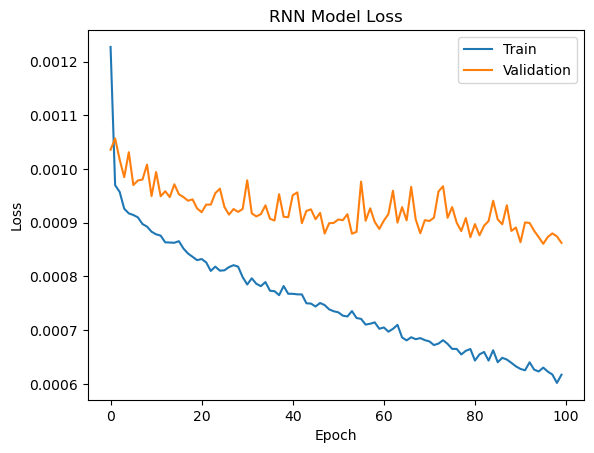

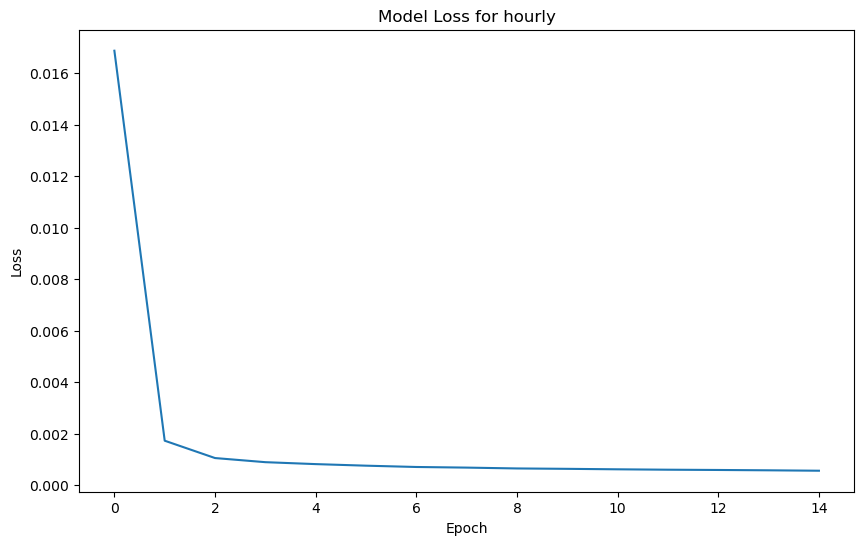

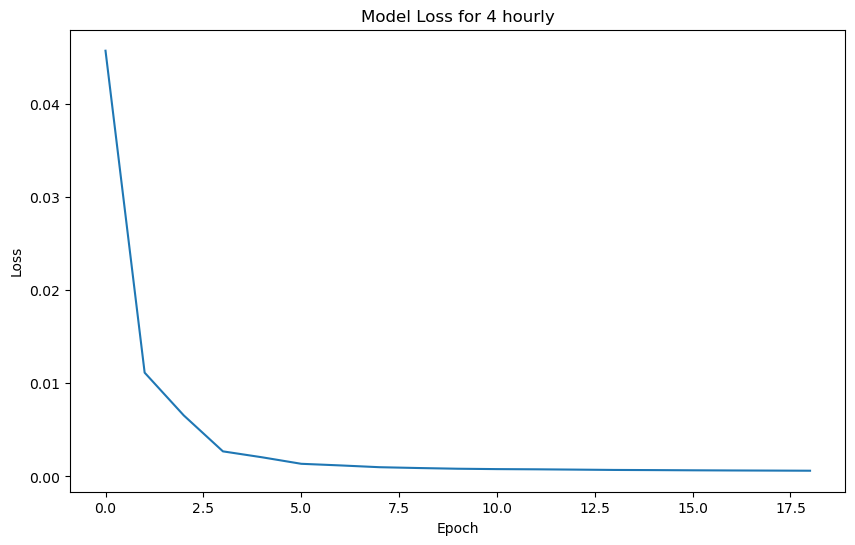

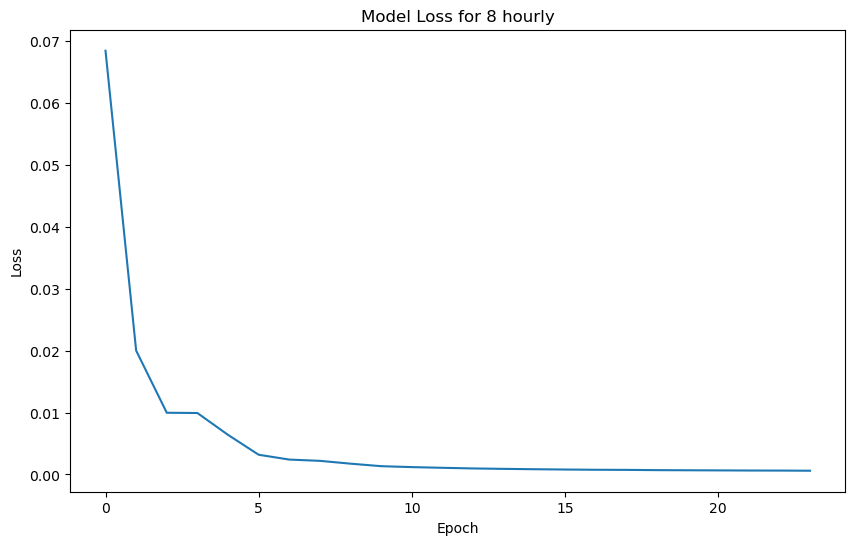

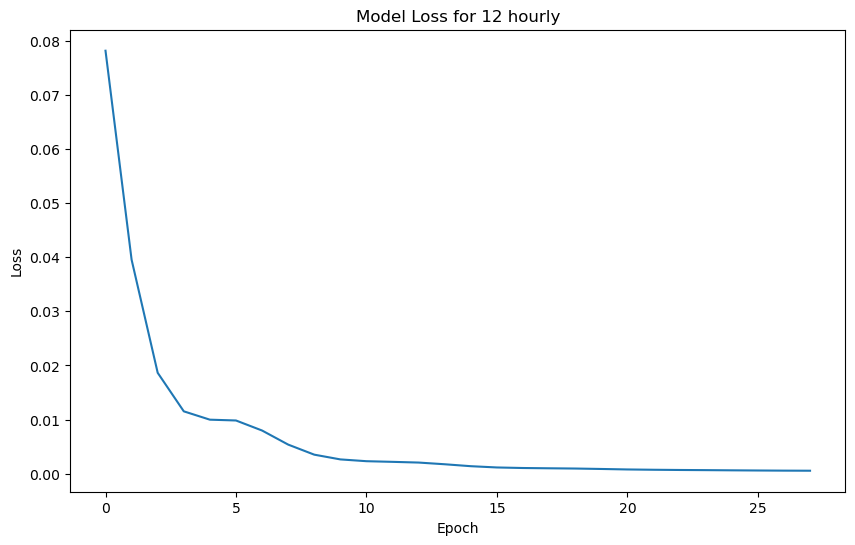

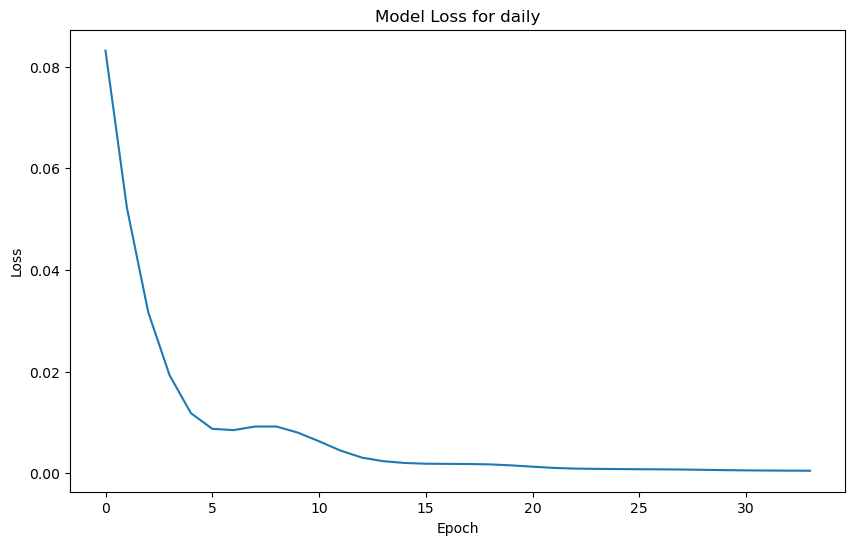

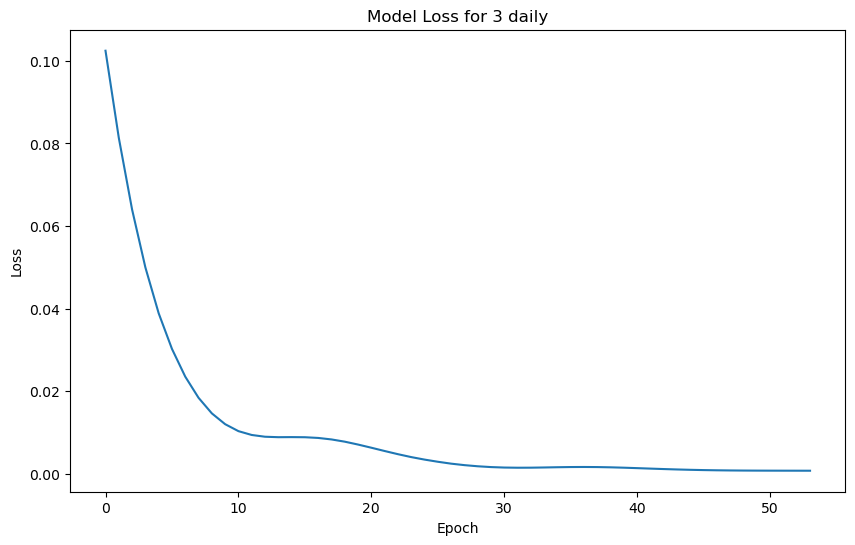

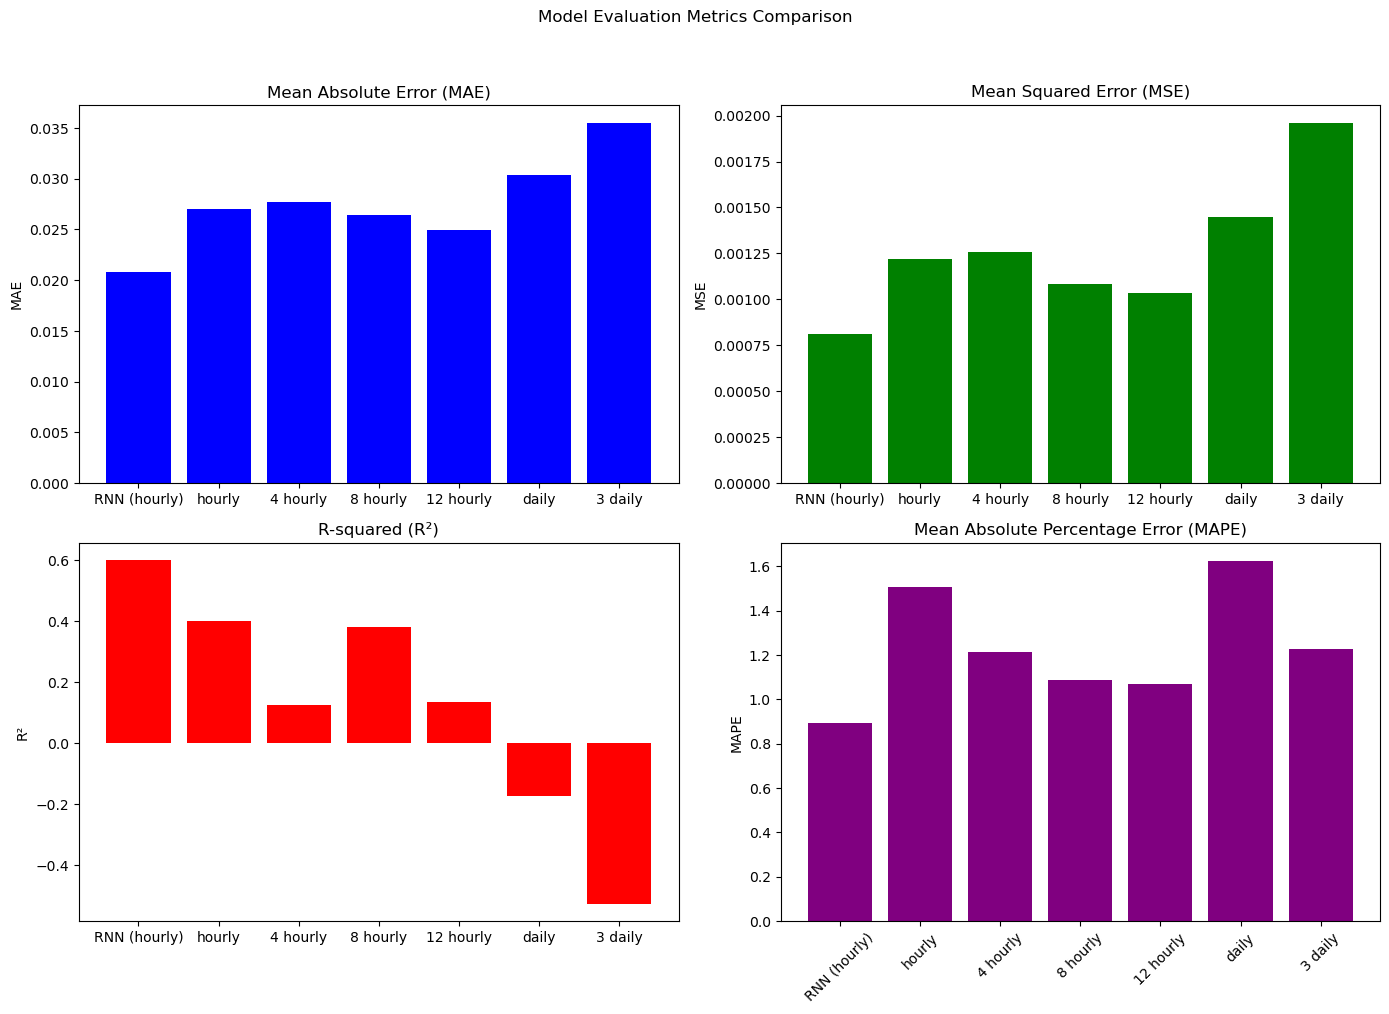

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.neural_network import MLPRegressor

# Define a function to train and evaluate a model
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)
    
    return model, predictions, mae, mse, r2, mape

# Function to reshape data for RNN input
def reshape_rnn_input(data):
    return data.reshape((data.shape[0], 1, data.shape[1]))

# Load and prepare data for the RNN model
daily_stat = pd.read_csv('hourly_stat.csv').dropna()
daily_stat['date'] = pd.to_datetime(daily_stat['date'])
features = daily_stat[['DWH_temp_mean', 'DWH_hum_mean', ]]
target = daily_stat['Gas_mean']
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(features_scaled, target, daily_stat['date'], test_size=0.2, random_state=42)
X_train_rnn = reshape_rnn_input(X_train)
X_test_rnn = reshape_rnn_input(X_test)

# Build and train the RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(192, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu', return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(32, activation='relu'))
rnn_model.add(Dense(8, activation='linear'))
rnn_model.add(Dense(4, activation='linear'))
rnn_model.add(Dense(1, activation='linear'))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
history_rnn = rnn_model.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.2)
rnn_predictions = rnn_model.predict(X_test_rnn).flatten()

# Calculate evaluation metrics for the RNN model
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_r2 = r2_score(y_test, rnn_predictions)
rnn_mape = mean_absolute_percentage_error(y_test, rnn_predictions)

# Plot training loss values for the RNN model
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Prepare datasets for different time periods for MLP models
datasets = {
    "hourly": pd.read_csv('hourly_stat.csv').dropna(),
    "4 hourly": pd.read_csv('hourly_4_stat.csv').dropna(),
    "8 hourly": pd.read_csv('hourly_8_stat.csv').dropna(),
    "12 hourly": pd.read_csv('hourly_12_stat.csv').dropna(),
    "daily": pd.read_csv('daily_stat.csv').dropna(),
    "3 daily": pd.read_csv('3_daily_stat.csv').dropna()
}

# Initialize metrics dictionary
metrics = {
    "Model": ["RNN (hourly)"],
    "MAE": [rnn_mae],
    "MSE": [rnn_mse],
    "R²": [rnn_r2],
    "MAPE": [rnn_mape]
}

# Train and evaluate MLP models for each dataset
for period, data in datasets.items():
    features = data[['SH_temp_mean', 'SH_hum_mean', 'DWH_temp_mean', 'DWH_hum_mean', 'ext_temp_mean', 'ext_hum_mean']].dropna()
    target = data['Gas_mean'].dropna()
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
    model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
    
    trained_model, predictions, mae, mse, r2, mape = train_and_evaluate_model(model, X_train, X_test, y_train, y_test)
    
    metrics["Model"].append(period)
    metrics["MAE"].append(mae)
    metrics["MSE"].append(mse)
    metrics["R²"].append(r2)
    metrics["MAPE"].append(mape)

    # Plotting training loss curve for each MLP model
    plt.figure(figsize=(10, 6))
    plt.plot(trained_model.loss_curve_)
    plt.title(f'Model Loss for {period}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame(metrics)

# Plotting the evaluation metrics for comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Evaluation Metrics Comparison')

# Plot MAE
axes[0, 0].bar(metrics_df['Model'], metrics_df['MAE'], color='blue')
axes[0, 0].set_title('Mean Absolute Error (MAE)')
axes[0, 0].set_ylabel('MAE')

# Plot MSE
axes[0, 1].bar(metrics_df['Model'], metrics_df['MSE'], color='green')
axes[0, 1].set_title('Mean Squared Error (MSE)')
axes[0, 1].set_ylabel('MSE')

# Plot R²
axes[1, 0].bar(metrics_df['Model'], metrics_df['R²'], color='red')
axes[1, 0].set_title('R-squared (R²)')
axes[1, 0].set_ylabel('R²')

# Plot MAPE
axes[1, 1].bar(metrics_df['Model'], metrics_df['MAPE'], color='purple')
axes[1, 1].set_title('Mean Absolute Percentage Error (MAPE)')
axes[1, 1].set_ylabel('MAPE')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.xticks(rotation=45)
plt.show()


In [ ]:
import math

# Calculate evaluation metrics
mae_LSTM_DWH  = mean_absolute_error(y_test, DWH_predictions)
mse_LSTM_DWH = mean_squared_error(y_test, DWH_predictions)
rmse_LSTM_DWH= math.sqrt(mse)
r2_LSTM_DWH = r2_score(y_test, DWH_predictions)
n = len(y_test)
p = X_test.shape[1]
adjusted_r2_LSTM_DWH = 1 - (1 - r2) * (n - 1) / (n - p - 1)
mape_LSTM_DWH = mean_absolute_percentage_error(y_test, DWH_predictions)

print(f'Mean Squared Error (MSE): {mae_LSTM_DWH }')
print(f'Root Mean Squared Error (RMSE): {mse_LSTM_DWH }')
print(f'R-squared (R²): {r2_LSTM_DWH }')
print(f'Adjusted R-squared (R²): {adjusted_r2_LSTM_DWH }')

print(f'Mean Absolute Error (MAE): {mae_LSTM_DWH }')
print(f'Mean Absolute Percentage Error (MAPE): {mape_LSTM_DWH }%')